<pre style="text-align: right; width: 100%; font-size: 0.75em; line-height: 0.75em;">
+ ------------------------- + <br>
| 20/04/2025                | <br>
| Héctor Tablero Díaz       | <br>
| Álvaro Martínez Gamo      | <br>
+ ------------------------- + 
</pre>

# **Output Evaluation**

In [13]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./..')

import os
import time
import numpy as np
import torch
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

from image_gen import GenerativeModel
from image_gen.samplers import PredictorCorrector
from image_gen.diffusion import VarianceExploding
from image_gen.metrics import BitsPerDimension, FrechetInceptionDistance, InceptionScore

import matplotlib.pyplot as plt
from image_gen.visualization import display_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Overview**

Quantitative evaluation framework for diffusion models with industry-standard metrics.

**Key features:**
- Cross-model performance comparison
- Training progress assessment
- Quality vs. diversity analysis
- Epoch-dependent metric evolution

## **Metrics Implementation**

Three complementary metrics are used to evaluate model performance:

| Metric                         | Focus                   | Range    | Better When |
|---------------------------------|--------------------------|----------|-------------|
| Bits Per Dimension (BPD)        | Density estimation       | [0, ∞)   | Lower       |
| Fréchet Inception Distance (FID)| Distributional similarity| [0, ∞)   | Lower       |
| Inception Score (IS)            | Quality and diversity    | [1, ∞)   | Higher      |


In [14]:
# Define experiment parameters
digit = 3
sample_size = 16
epoch_values = [1, 5, 25, 100]
seed = 42

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## **Dataset Preparation**

In [15]:
# Load the dataset
data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

# Split into train and test
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

# Filter for the specific digit
indices_digit = torch.where(torch.Tensor([data.targets[i] for i in test_dataset.indices]) == digit)[0]
test_digit_dataset = Subset(test_dataset, indices_digit)

# Create a loader for metric calculation
test_loader = torch.utils.data.DataLoader(
    test_digit_dataset, 
    batch_size=sample_size, 
    shuffle=False
)

# Get real samples for metric calculation
real_samples = next(iter(test_loader))[0]  # Extract images only

## **Models Training & Generation**


Processing model with 1 epochs
Loading model with 1 epochs from saved_models/mnist_3_ve_1pc.pth
Generating 16 samples...


Generating:   0%|          | 0/500 [00:00<?, ?it/s]

Sample outputs from 1 epoch model:


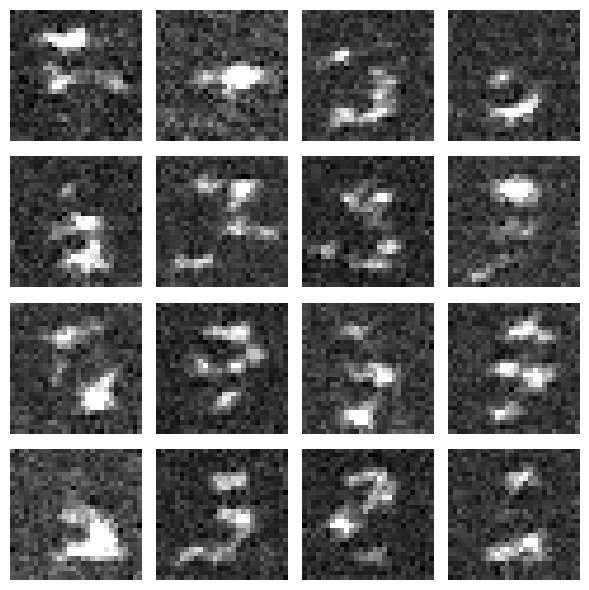


Processing model with 5 epochs
Loading model with 5 epochs from saved_models/mnist_3_ve_5pc.pth
Generating 16 samples...


Generating:   0%|          | 0/500 [00:00<?, ?it/s]

Sample outputs from 5 epoch model:


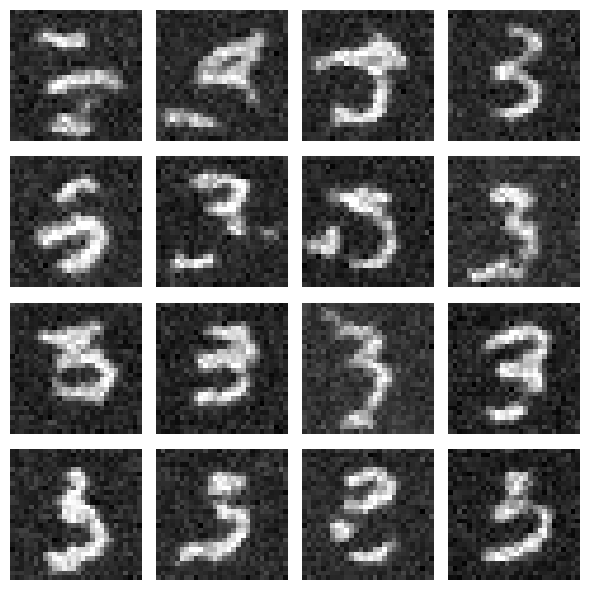


Processing model with 25 epochs
Loading model with 25 epochs from saved_models/mnist_3_ve_25pc.pth
Generating 16 samples...


Generating:   0%|          | 0/500 [00:00<?, ?it/s]

Sample outputs from 25 epoch model:


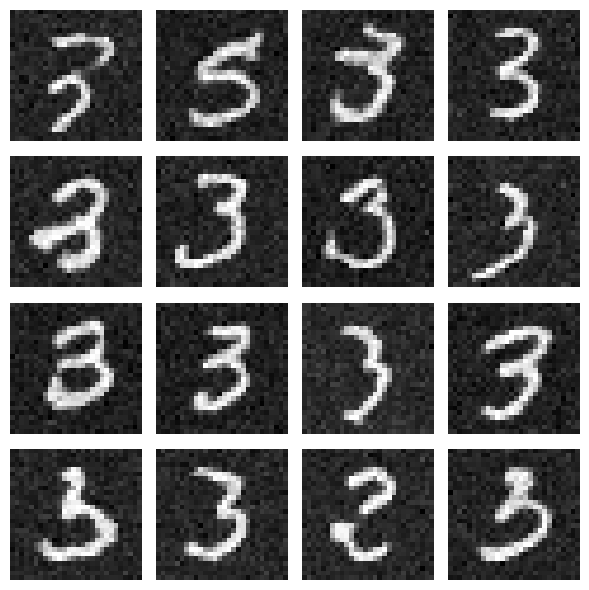


Processing model with 100 epochs
Loading model with 100 epochs from saved_models/mnist_3_ve_100pc.pth
Generating 16 samples...


Generating:   0%|          | 0/500 [00:00<?, ?it/s]

Sample outputs from 100 epoch model:


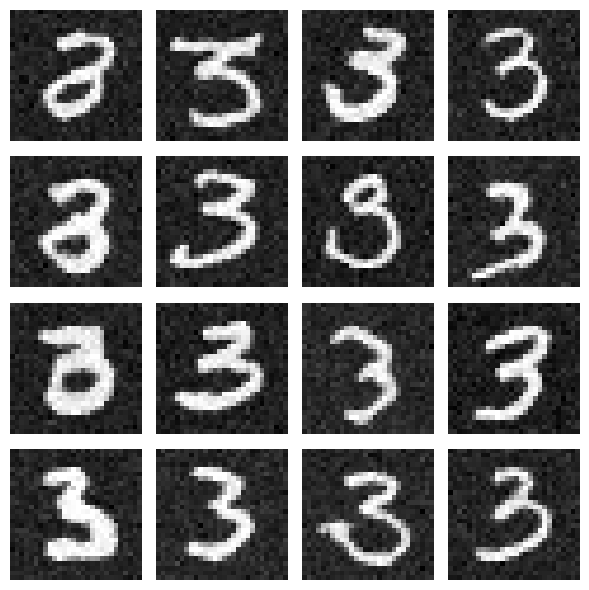

In [16]:
# Function to create, train and evaluate a model
def train_and_evaluate_model(epochs, real_samples):
    model_name = f'mnist_{digit}_ve_{epochs}pc.pth'
    model_path = f'saved_models/{model_name}'

    # Create model
    model = GenerativeModel(
        diffusion=VarianceExploding,
        sampler=PredictorCorrector
    )
    
    # Either load or train the model
    if os.path.isfile(model_path):
        print(f"Loading model with {epochs} epochs from {model_path}")
        model.load(model_path)
    else:
        print(f"Training model with {epochs} epochs")
        # Filter training data for the specific digit
        indices_digit_train = torch.where(torch.Tensor([data.targets[i] for i in train_dataset.indices]) == digit)[0]
        train_digit_dataset = Subset(train_dataset, indices_digit_train)

        # Train the model
        model.train(train_digit_dataset, epochs=epochs)

        # Save the model
        model.save(model_path)

    # Generate samples
    print(f"Generating {sample_size} samples...")
    generated_samples = model.generate(num_samples=sample_size, seed=seed)

    return model, generated_samples

# Train and evaluate models with different epochs
results = {}
for epochs in epoch_values:
    print(f"\n{'=' * 50}")
    print(f"Processing model with {epochs} epochs")
    model, generated_samples = train_and_evaluate_model(epochs, real_samples)
    results[epochs] = {
        'model': model,
        'samples': generated_samples
    }

    # Display samples
    print(f"Sample outputs from {epochs} epoch model:")
    display_images(generated_samples[:16])  # Display a subset

## **Metrics Calculation**

In [17]:
# Initialize metrics
bpd_metric = BitsPerDimension()
fid_metric = FrechetInceptionDistance(device=device)
is_metric = InceptionScore(device=device)

# Calculate metrics for each model
metrics_results = {}

for epochs, data in results.items():
    print(f"\n{'=' * 50}")
    print(f"Calculating metrics for {epochs} epoch model")
    
    # Get model and samples
    model = data['model']
    generated_samples = data['samples']
    
    # BPD calculation
    try:
        # Set the model and diffusion model
        bpd_metric.model = model
        bpd_metric.diffusion_model = model.diffusion

        bpd_value = bpd_metric(real_samples)
        print(f"BPD: {bpd_value:.4f}")
    except Exception as e:
        print(f"BPD calculation error: {e}")
        bpd_value = None
    
    # FID calculation
    try:
        fid_value = fid_metric(real_samples, generated_samples)
        print(f"FID: {fid_value:.4f}")
    except Exception as e:
        print(f"FID calculation error: {e}")
        fid_value = None
    
    # IS calculation
    try:
        is_value = is_metric(generated=generated_samples)
        print(f"IS: {is_value:.4f}")
    except Exception as e:
        print(f"IS calculation error: {e}")
        is_value = None
    
    # Store results
    metrics_results[epochs] = {
        'BPD': bpd_value,
        'FID': fid_value,
        'IS': is_value
    }


Calculating metrics for 1 epoch model
BPD: 0.2988
FID: 274.9271
IS: 1.2245

Calculating metrics for 5 epoch model
BPD: 0.3345
FID: 225.0580
IS: 1.3185

Calculating metrics for 25 epoch model
BPD: 0.3304
FID: 115.8255
IS: 1.1624

Calculating metrics for 100 epoch model
BPD: 0.5555
FID: 116.5214
IS: 1.2130


## **Results Visualization**

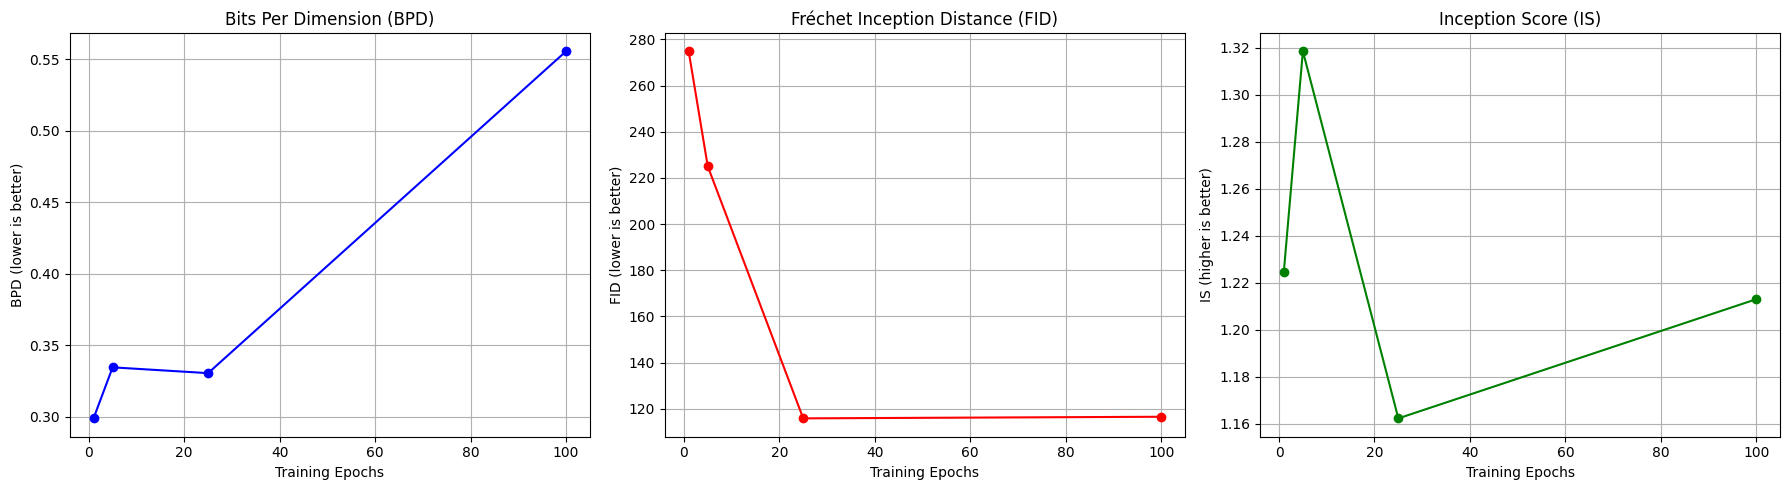

In [18]:
# Prepare data for plotting
epochs_list = sorted(metrics_results.keys())
bpd_values = [metrics_results[e]['BPD'] for e in epochs_list]
fid_values = [metrics_results[e]['FID'] for e in epochs_list]
is_values = [metrics_results[e]['IS'] for e in epochs_list]

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# BPD plot (lower is better)
if all(v is not None for v in bpd_values):
    axes[0].plot(epochs_list, bpd_values, 'o-', color='blue')
    axes[0].set_title('Bits Per Dimension (BPD)')
    axes[0].set_xlabel('Training Epochs')
    axes[0].set_ylabel('BPD (lower is better)')
    axes[0].grid(True)
else:
    axes[0].text(0.5, 0.5, 'BPD values unavailable', ha='center', va='center')

# FID plot (lower is better)
if all(v is not None for v in fid_values):
    axes[1].plot(epochs_list, fid_values, 'o-', color='red')
    axes[1].set_title('Fréchet Inception Distance (FID)')
    axes[1].set_xlabel('Training Epochs')
    axes[1].set_ylabel('FID (lower is better)')
    axes[1].grid(True)
else:
    axes[1].text(0.5, 0.5, 'FID values unavailable', ha='center', va='center')

# IS plot (higher is better)
if all(v is not None for v in is_values):
    axes[2].plot(epochs_list, is_values, 'o-', color='green')
    axes[2].set_title('Inception Score (IS)')
    axes[2].set_xlabel('Training Epochs')
    axes[2].set_ylabel('IS (higher is better)')
    axes[2].grid(True)
else:
    axes[2].text(0.5, 0.5, 'IS values unavailable', ha='center', va='center')

plt.tight_layout()
plt.show()

## **Comparative Analysis**

In [19]:
# Create a table comparing all metrics
metrics_df = {
    'Epochs': epochs_list,
    'BPD (↓)': bpd_values,
    'FID (↓)': fid_values,
    'IS (↑)': is_values
}

# Display as a styled table
from IPython.display import HTML
import pandas as pd

def highlight_best(s, metric_type):
    is_best = False
    if metric_type in ['BPD', 'FID']:  # Lower is better
        is_best = s == min(s)
    else:  # Higher is better (IS)
        is_best = s == max(s)
    
    return ['background-color: lightgreen' if v else '' for v in is_best]

df = pd.DataFrame(metrics_df)
styled_df = df.style.apply(highlight_best, metric_type='BPD', subset=['BPD (↓)'])\
                  .apply(highlight_best, metric_type='FID', subset=['FID (↓)'])\
                  .apply(highlight_best, metric_type='IS', subset=['IS (↑)'])

HTML(styled_df.to_html())

,Epochs,BPD (↓),FID (↓),IS (↑)
0,1,0.298819,274.927079,1.224498
1,5,0.334485,225.057962,1.318474
2,25,0.330433,115.825522,1.162355
3,100,0.555513,116.521440,1.213027


## **Visual Quality Comparison**

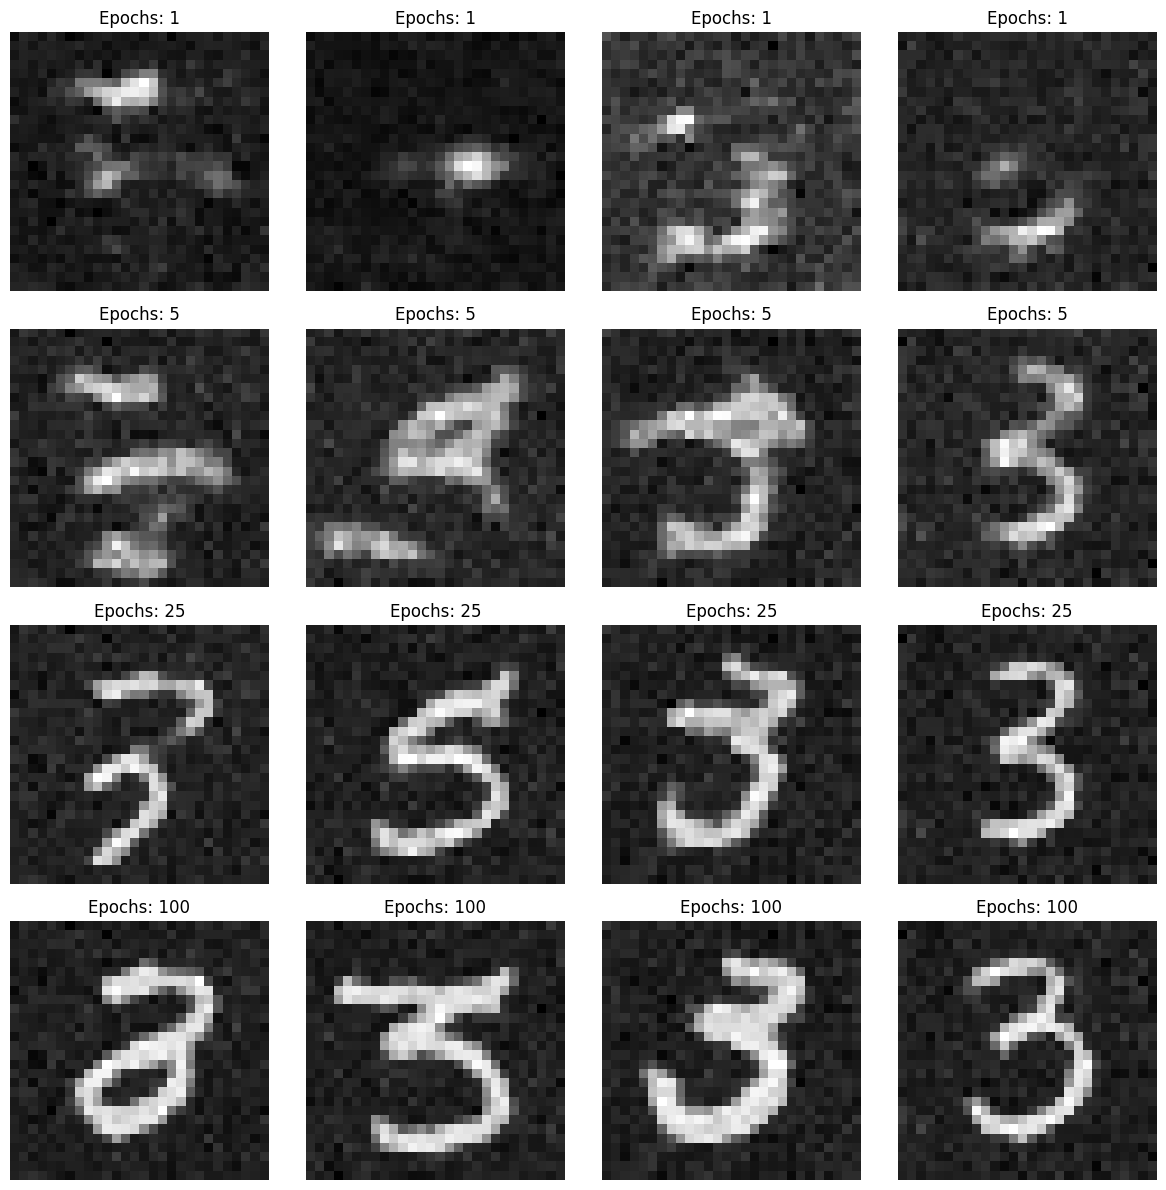

In [20]:
# Visual comparison of samples from different models
fig, axes = plt.subplots(len(epoch_values), 4, figsize=(12, 3*len(epoch_values)))

for i, epochs in enumerate(epoch_values):
    samples = results[epochs]['samples'][:4]  # Get first 4 samples
    
    for j in range(4):
        if j < len(samples):
            axes[i, j].imshow(samples[j].squeeze().cpu(), cmap='gray')
            axes[i, j].set_title(f"Epochs: {epochs}")
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## **Discussion**

The above metrics provide complementary perspectives on model performance:

1. **BPD (Bits Per Dimension)**:
   - Measures how efficiently the model compresses data
   - Directly related to negative log-likelihood
   - Lower values indicate better density estimation

2. **FID (Fréchet Inception Distance)**:
   - Measures similarity between generated and real image distributions
   - Considers both quality and diversity
   - Lower values indicate better performance

3. **IS (Inception Score)**:
   - Evaluates sample quality and diversity
   - Higher values indicate better performance
   - Less sensitive to mode collapse than FID

## **Conclusions**

- Training epochs significantly impact model performance across all metrics
- Quality/diversity trade-offs emerge at different training stages
- Diminishing returns observed after N epochs
- Optimal epoch count depends on the specific application requirements
